In [780]:
import pandas as pd
import logging
import dateutil
from dateutil import parser
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [781]:
#import dataset of final cleaned projects from "data" folder
file = "../../../data/cleaned/final_cleaned_projects.csv"
output="../../Output/Entire Sample/"
df = pd.read_csv(file)

# Merge in Geographic Information and Make Big Dataframe

In [782]:
#first, convert points to geodataframe
crs = {'init' :'epsg:4326'}
geometry = [Point(xy) for xy in zip(df.x, df.y)]
devs = GeoDataFrame(df, crs=crs, geometry=geometry)
devs = devs.to_crs({'init': 'epsg:4326'}) 

In [783]:
#import neighborhoods
neighborhoods = gpd.read_file('../../../data/gis/41_neighborhoods/41_neighborhoods.shp')

In [784]:
#convert boundaries to geographic coordinate system to conform to points
neighborhoods = neighborhoods.to_crs({'init': 'epsg:4326'}) 

In [785]:
#First, spatial join between points and neighborhood boundaries. Set 'how' to 'left' to preserve all developments
df = gpd.sjoin(devs, neighborhoods, how = 'inner', op='within')
df.shape

(2474, 44)

In [786]:
#Create Big Projects Dataframe
df_big=df[df['units']>=10]
df_big['project_time_years'].describe()

count    137.000000
mean       6.255254
std        3.453810
min        0.750685
25%        3.854795
50%        5.945205
75%        8.273973
max       24.128767
Name: project_time_years, dtype: float64

In [787]:
# Top 5 shortest projects of big projects
df_big.sort_values('project_time_years', ascending = True)[0:5]

,Unnamed: 0,Unnamed: 0.1,BP_date,address_x,aff,affnet,apn,best_date,best_stat,comp_date,con_date,dbi_permit,dropped_out,first_date,first_project_record_date,firstfiled,latest_project_record_date,latest_project_status,project_dates,project_duration_days,project_statuses,report_quarter,report_year,status,units,unitsnet,x,y,zoning,zoning_simplified,bp_duplicates,project_time_years,aff_address,address_y,Low Income Units,Placed in Service (PIS) Date,iz_address,Total BMRs in this Building or Phase,Planning Approval Date,Completion Date,_merge,geometry,index_right,nhood
913,913,0,NaN,1155 MARKET ST,0.0,0.0,3702054,2016-02-23,CONSTRUCTION,04/01/2016,2016-02-23,201507020526,False,2015-07-02,2016-02-23,2015-07-02,2016-02-23,CONSTRUCTION,"('2016-02-23',)",274.0,"('CONSTRUCTION',)",1,2016,Under Construction,11.0,11.0,-122.413409,37.779223,C-3-G,C-3-G,False,0.750685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,POINT (-122.413409 37.7792227726),33,South of Market
1237,1237,0,2015-07-24,555 POST ST,0.0,0.0,0306020,2016-02-29,CONSTRUCTION,04/01/2016,2016-02-29,201504224344,False,2015-04-22,2015-07-24,2015-04-22,2016-02-29,CONSTRUCTION,"('2015-07-24', '2015-07-24', '2016-01-04', '20...",345.0,"('BP ISSUED', 'BP ISSUED', 'BP ISSUED', 'CONST...",1,2016,Under Construction,17.0,17.0,-122.410943,37.787683,C-3-G,C-3-G,False,0.945205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,POINT (-122.410943 37.787682827),35,Tenderloin
2256,2256,0,2013-07-23,1816 EDDY ST,NaN,0.0,1127064,2014-02-07,CONSTRUCTION,07/01/2014,2014-02-07,201304265571,False,2013-04-26,2013-07-23,2013-04-26,2014-02-07,CONSTRUCTION,"('2013-07-23', '2013-07-23', '2014-02-07', '20...",431.0,"('BP ISSUED', 'BP ISSUED', 'CONSTRUCTION', 'CO...",2,2014,Under Construction,19.0,19.0,-122.437260,37.780796,RM-3,RM-3,False,1.180822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,POINT (-122.43726 37.780796),40,Western Addition
64,64,0,2011-08-16,350 GOLDEN GATE AV,69.0,NaN,0346005,2012-02-13,CONSTRUCTION,04/01/2012,2012-01-13,201011014101,False,2010-11-01,2010-11-01,2010-11-01,2012-02-13,CONSTRUCTION,"('2010-11-01', '2010-11-01', '2010-11-01', '20...",517.0,"('BP FILED', 'BP FILED', 'BP FILED', 'BP ISSUE...",1,2012,Under Construction,19.0,19.0,-122.416512,37.781546,C-3-G,C-3-G,False,1.416438,350 GOLDEN GATE AVENUE,350 GOLDEN GATE AVENUE,69.0,2012-08-01,NaN,NaN,NaN,NaN,left_only,POINT (-122.4165125 37.781546),35,Tenderloin
1123,1123,0,2016-01-22,1300 04TH ST,0.0,0.0,8711021,2016-10-25,CONSTRUCTION,01/01/2017,2016-10-25,201507272485,False,2015-07-27,2015-07-27,2015-07-27,2016-10-25,CONSTRUCTION,"('2015-07-27', '2015-07-27', '2016-01-22', '20...",524.0,"('BP FILED', 'BP FILED', 'BP ISSUED', 'BP ISSU...",4,2016,Under Construction,143.0,143.0,-122.391772,37.771402,MB-RA,MB-RA,False,1.435616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,POINT (-122.391771649 37.77140196040001),19,Mission Bay


In [788]:
#in order to use as much data as possible, I am not keeping all data and just creating time vars where we can (i.e. where they are nonnull)
def permit_time(value):
    returnval=np.nan
    if pd.notnull(value['BP_date']) & pd.notnull(value['first_date']):
        returnval=((dateutil.parser.parse(value['BP_date']) - dateutil.parser.parse(value['first_date'])).days)/365
    return returnval
def bp_time(value):
    returnval=np.nan
    if pd.notnull(value['con_date']) & pd.notnull(value['BP_date']):
        returnval=((dateutil.parser.parse(value['con_date']) - dateutil.parser.parse(value['BP_date'])).days)/365
    return returnval
def con_time(value):
    returnval=np.nan
    if pd.notnull(value['comp_date']) & pd.notnull(value['con_date']):
        returnval=((dateutil.parser.parse(value['comp_date']) - dateutil.parser.parse(value['con_date'])).days)/365
    return returnval
    
df['permit_time']=df.apply(permit_time, axis=1)
df['bp_time']=df.apply(bp_time, axis=1)
df['con_time']=df.apply(con_time, axis=1)

#per unit variables
df['ptime_per_unit']=df['permit_time']/df['units']
df['bptime_per_unit']=df['bp_time']/df['units']
df['contime_per_unit']=df['con_time']/df['units']

## Export Polygon Shapefile

In [789]:
# Export Polygon Shapefile
#First, spatial join between points and neighborhood boundaries. Set 'how' to 'left' to preserve all developments
nbdf = gpd.sjoin(devs, neighborhoods, how = 'right', op='within')

In [790]:
#in order to use as much data as possible, I am not keeping all data and just creating time vars where we can (i.e. where they are nonnull)
def permit_time(value):
    returnval=np.nan
    if pd.notnull(value['BP_date']) & pd.notnull(value['first_date']):
        returnval=((dateutil.parser.parse(value['BP_date']) - dateutil.parser.parse(value['first_date'])).days)/365
    return returnval
def bp_time(value):
    returnval=np.nan
    if pd.notnull(value['con_date']) & pd.notnull(value['BP_date']):
        returnval=((dateutil.parser.parse(value['con_date']) - dateutil.parser.parse(value['BP_date'])).days)/365
    return returnval
def con_time(value):
    returnval=np.nan
    if pd.notnull(value['comp_date']) & pd.notnull(value['con_date']):
        returnval=((dateutil.parser.parse(value['comp_date']) - dateutil.parser.parse(value['con_date'])).days)/365
    return returnval
    
nbdf['permit_time']=nbdf.apply(permit_time, axis=1)
nbdf['bp_time']=nbdf.apply(bp_time, axis=1)
nbdf['con_time']=nbdf.apply(con_time, axis=1)

In [791]:
nbdf['years_per_unit']=nbdf['project_time_years']/nbdf['units']
nbdf['ptime_per_unit']=nbdf['permit_time']/nbdf['units']

In [792]:
#Next, dissolve by neighborhoods to get sum of units
nbdf = nbdf[['nhood', 'geometry', 'years_per_unit', 'ptime_per_unit']]
nbdf_med = nbdf.dissolve(by=['nhood'], aggfunc='median')
nbdf_med.head()

,geometry,years_per_unit,ptime_per_unit
nhood,,,
Bayview Hunters Point,POLYGON ((-122.3815777424142 37.75307043091241...,0.868493,0.597260
Bernal Heights,"POLYGON ((-122.403612999828 37.74933700015653,...",2.904110,1.716438
Castro/Upper Market,POLYGON ((-122.4265550005568 37.76948499984702...,2.928767,0.912329
Chinatown,POLYGON ((-122.4062259995664 37.79755900029376...,3.443836,0.364384
Excelsior,POLYGON ((-122.4239820002333 37.73155199975518...,1.615068,0.632877


In [793]:
output2="../../Output/"
nbdf_med['nbhood']=nbdf_med.index
nbdf_med.to_file(driver='ESRI Shapefile',filename=output2+"nbds.shp")

In [794]:
nbdf_med['nbhood']=nbdf_med.index
nbdf_med.head()

,geometry,years_per_unit,ptime_per_unit,nbhood
nhood,,,,
Bayview Hunters Point,POLYGON ((-122.3815777424142 37.75307043091241...,0.868493,0.597260,Bayview Hunters Point
Bernal Heights,"POLYGON ((-122.403612999828 37.74933700015653,...",2.904110,1.716438,Bernal Heights
Castro/Upper Market,POLYGON ((-122.4265550005568 37.76948499984702...,2.928767,0.912329,Castro/Upper Market
Chinatown,POLYGON ((-122.4062259995664 37.79755900029376...,3.443836,0.364384,Chinatown
Excelsior,POLYGON ((-122.4239820002333 37.73155199975518...,1.615068,0.632877,Excelsior


# Zoning Exploration

In [795]:
df['zoning_simplified'].value_counts()

conv_res = ['RH-1(D)', 'RH-1', 'RH-1(S)', 'RH-2', 'RH-3']
apt_res=['RM-1', 'RM-2', 'RM-3', 'RM-4']
mixed_res=['RC-3', 'RC-4', 'RED', 'RTO', 'RC-4']
nhb_comm=['NC-1', 'NC-2', 'NC-3', 'NC-S', 'NCD', 'NCT'] #NCD and NCT encompass all types of NCD, NCTs
comm=['C-2', 'C-3', 'C-M']
indus=['M-1', 'M-2']
other=[]

def zoning_simple(value):
    if pd.isnull(value['zoning']):
        zone_class = ''
    else:
        zone_class='Other'
        for item in conv_res:
            if value['zoning'].find(item)>=0:
                zone_class= 'Conventional Residential'
        for item in apt_res:
            if value['zoning'].find(item)>=0: 
                zone_class= 'Apartment Residential'
        for item in mixed_res:
            if value['zoning'].find(item)>=0: 
                zone_class= 'Mixed Residential'
        for item in nhb_comm:
            if value['zoning'].find(item)>=0: 
                zone_class= 'Nhb Commercial'
        for item in comm:
            if value['zoning'].find(item)>=0: 
                zone_class= 'Standard Commercial'
        for item in indus:
            if value['zoning'].find(item)>=0: 
                zone_class= 'Industrial'
    return zone_class

df['zone_class']=df.apply(zoning_simple, axis=1)

In [796]:
df['zone_class'].value_counts()

Conventional Residential    939
                            667
Other                       242
Standard Commercial         177
Industrial                  164
Nhb Commercial              145
Mixed Residential           116
Apartment Residential        24
Name: zone_class, dtype: int64

In [797]:
def bar_graph(var_x,var_y, title, x_label, y_label, df=df, sortedvar=False, graph_options=['red', (8, 6)]):
    """
    Function to make bar graphs by subgroup for median time to completion.
    """
    medians=[]
    sample_size=0
    value_names=df[var_x].value_counts(sort=False).index
    if sortedvar==True:
        value_names=sorted(value_names, key=lambda x: df[df[var_x]==x][var_y].median())
    for i in value_names:
        median = df[df[var_x]==i][var_y].median()
        sample_size=sample_size+df[df[var_x]==i][var_y].count() #count sample size for non-missing y variable
        medians.append(median)
        
    y_pos = np.arange(len(df[var_x].value_counts(sort=False).index))
    categories=[]
    for cat in value_names:
        categories.append(cat)
        
    fig, ax = plt.subplots(figsize=graph_options[1])
    plt.title(title+ ' n='+ str(sample_size), fontsize=20)
    ax.bar(y_pos, medians, align='center', alpha=0.5, color = graph_options[0])
    ax.set_xticks(y_pos)
    ax.set_xticklabels(categories, rotation=45)
    ax.set_xlabel(x_label, fontsize=20)
    ax.set_ylabel(y_label, fontsize=20)
    for tick in ax.xaxis.get_majorticklabels():
        tick.set_horizontalalignment("right")
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.show()

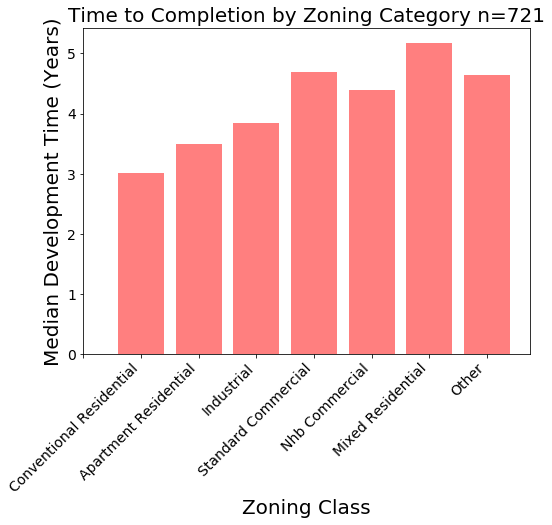

In [798]:
bar_graph('zone_class','project_time_years', 'Time to Completion by Zoning Category','Zoning Class', 'Median Development Time (Years)')

# Project Times by Years

In [799]:
df['year_start']=df['first_date'].str[0:4].astype(int)

In [800]:
year_medians=[]
for i in df['year_start'].value_counts(sort=False).index:
    median = df[df['year_start']==i]['project_time_years'].median()
    year_medians.append(median)

In [801]:
y_pos = np.arange(len(df['year_start'].value_counts(sort=False).index))

In [802]:
categories=[]
for cat in df['year_start'].value_counts(sort=False).index:
    categories.append(cat)

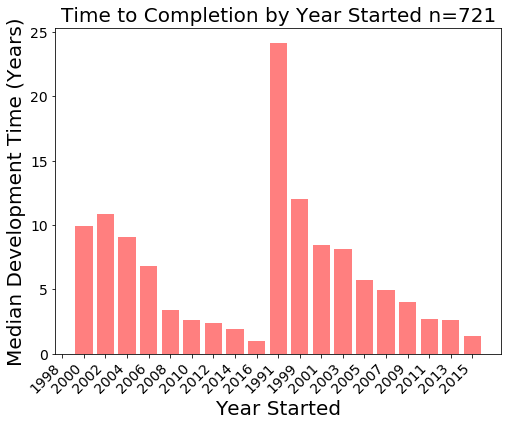

In [803]:
bar_graph('year_start','project_time_years', 'Time to Completion by Year Started','Year Started', 'Median Development Time (Years)')

In [804]:
df['first_year']=df['year_start'].astype(int)

(0, 20)

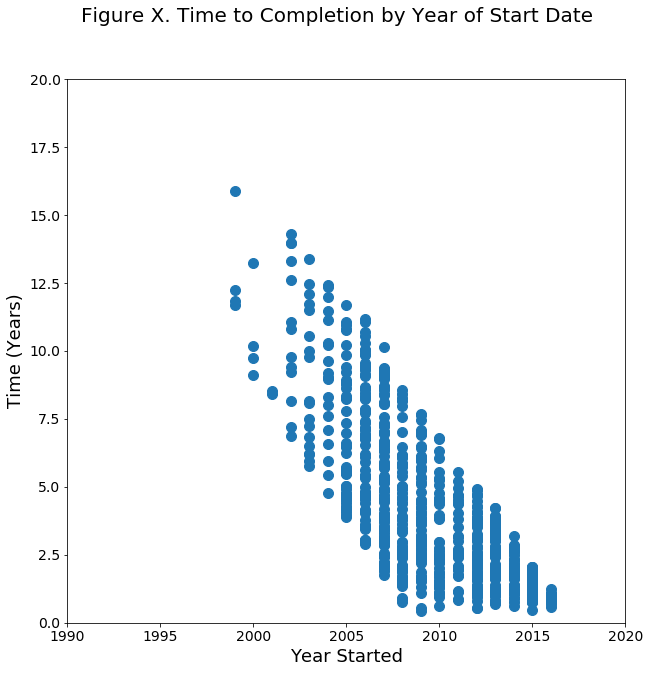

In [805]:
plt.figure(1, figsize=(10,10))
plt.scatter(df['first_year'], df['project_time_years'], s=100)
plt.suptitle('Figure X. Time to Completion by Year of Start Date', fontsize=20)
plt.ylabel('Time (Years)', fontsize = 18)
plt.xlabel('Year Started', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize = 14)
plt.xlim([1990,2020])
plt.ylim([0,20])
#plt.savefig(output+'scatter.png')

In [806]:
df[df['dropped_out']==True]

,Unnamed: 0,Unnamed: 0.1,BP_date,address_x,aff,affnet,apn,best_date,best_stat,comp_date,con_date,dbi_permit,dropped_out,first_date,first_project_record_date,firstfiled,latest_project_record_date,latest_project_status,project_dates,project_duration_days,project_statuses,report_quarter,report_year,status,units,unitsnet,x,y,zoning,zoning_simplified,bp_duplicates,project_time_years,aff_address,address_y,Low Income Units,Placed in Service (PIS) Date,iz_address,Total BMRs in this Building or Phase,Planning Approval Date,Completion Date,_merge,geometry,index_right,nhood,permit_time,bp_time,con_time,ptime_per_unit,bptime_per_unit,contime_per_unit,zone_class,year_start,first_year
33,33,0,NaN,2435-2445 16TH ST,6.0,6.0,3965021,2015-03-25,PL FILED,NaN,NaN,NaN,True,2014-08-01,2015-03-25,2014-08-01,2015-03-25,PL FILED,"('2015-03-25', '2015-03-25', '2015-03-25')",NaN,"('PL FILED', 'PL FILED', 'PL FILED')",3,2015,Proposed,53.0,53.0,-122.411120,37.765321,UMU,UMU,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,POINT (-122.411119977 37.7653208742),18,Mission,NaN,NaN,NaN,NaN,NaN,NaN,Other,2014,2014
83,83,0,NaN,3140 16TH ST,0.0,0.0,3555018,2016-07-27,PL APPROVED,NaN,NaN,NaN,True,2014-07-10,2015-05-11,2014-07-10,2016-07-27,PL APPROVED,"('2015-05-11', '2015-05-11', '2015-05-11', '20...",NaN,"('PL FILED', 'PL FILED', 'PL FILED', 'PL APPRO...",4,2016,Proposed,4.0,4.0,-122.422891,37.765106,NCT,NCT,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,POINT (-122.422891127 37.7651062252),18,Mission,NaN,NaN,NaN,NaN,NaN,NaN,Nhb Commercial,2014,2014
110,110,0,NaN,3424 26TH ST,NaN,NaN,6529012B,2007-06-20,BP FILED,NaN,NaN,200706204570,True,2007-06-20,2007-06-20,2007-06-20,2007-06-20,BP FILED,"('2007-06-20', '2007-06-20', '2007-06-20')",NaN,"('BP FILED', 'BP FILED', 'BP FILED')",1,2010,Proposed,3.0,3.0,-122.419314,37.749033,RTO-M,RTO-M,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,POINT (-122.419314 37.749033),18,Mission,NaN,NaN,NaN,NaN,NaN,NaN,Mixed Residential,2007,2007
145,145,0,NaN,658 - 666 SHOTWELL ST,0.0,0.0,3611062,2013-10-10,PL APPROVED,NaN,NaN,NaN,True,2010-02-18,2013-10-10,2010-02-18,2013-10-10,PL APPROVED,"('2013-10-10',)",NaN,"('PL APPROVED',)",1,2016,Proposed,1.0,1.0,-122.416001,37.757828,RH-3,RH-3,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,POINT (-122.416001 37.7578281854),18,Mission,NaN,NaN,NaN,NaN,NaN,NaN,Conventional Residential,2010,2010
295,295,0,2010-10-21,3360 20TH ST,0.0,0.0,3594016,2010-10-21,BP APPROVED,NaN,NaN,200512200747,True,2005-08-23,2005-12-20,2005-08-23,2010-10-21,BP APPROVED,"('2005-12-20', '2005-12-20', '2005-12-20', '20...",NaN,"('BP FILED', 'BP FILED', 'BP FILED', 'BP FILED...",1,2016,Building Permit Approved,6.0,6.0,-122.416153,37.759027,NC-2,NC-2,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,POINT (-122.416153 37.7590266075),18,Mission,5.164384,NaN,NaN,0.860731,NaN,NaN,Standard Commercial,2005,2005
345,345,0,NaN,953 TREAT AV (BLDG 1 OF 2),0.0,0.0,3639028,2015-11-04,BP FILED,NaN,NaN,201511041763,True,2015-07-10,2015-11-04,2015-07-10,2015-11-04,BP FILED,"('2015-11-04',)",NaN,"('BP FILED',)",4,2016,Proposed,2.0,2.0,-122.413030,37.755100,UMU,UMU,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,POINT (-122.413030219 37.7550997463),18,Mission,NaN,NaN,NaN,NaN,NaN,NaN,Other,2015,2015
349,349,0,NaN,1008 ALABAMA ST,NaN,NaN,4148002,2004-10-29,BP FILED,NaN,NaN,200410298059,True,2004-10-29,2004-10-29,2004-10-29,2004-10-29,BP FILED,"('2004-10-29',)",NaN,"('BP FILED',)",3,2009,Proposed,1.0,1.0,-122.411408,37.755610,RH-3,RH-3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,POINT (-122.411408 37.75561),18,Mission,NaN,NaN,NaN,NaN,NaN,NaN,Conventional Residential,2004,2004
378,378,0,2008-04-22,160 14TH ST,NaN,NaN,3530049,2008-04-22,BP ISSUED,NaN,NaN,200710034503,True,2007-10-03,2008-04-22,2007-10-03,2008-04-22,BP ISSUED,"('2008-04-22', '2008-04-22', '2008-04-22', '20...",NaN,"('BP ISSUED', 'BP ISSUED', 'BP ISSUED', 'BP IS...",3,2013,Building Permit Approved,1.0,1.0,-122.416954,37.768553,PDR-1-G,PDR-1-G,False,NaN,

# Figure 1. Histograms

In [807]:
df.to_csv(output+'data.csv')

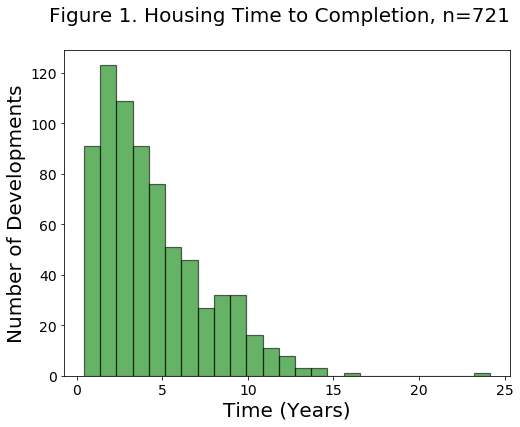

In [808]:
plt.figure(1, figsize=(8,6), )
plt.suptitle('Figure 1. Housing Time to Completion,' + ' n='+str(df[pd.notnull(df['project_time_years'])].count()['project_time_years']), fontsize=20)
plt.xlabel('Time (Years)', fontsize = 20)
plt.ylabel('Number of Developments', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
ax = plt.hist(df[pd.notnull(df['project_time_years'])]['project_time_years'], bins=25, alpha=.6, color='g',  edgecolor='black', linewidth=1.2)
plt.savefig(output+'hitogram.png')
plt.show()

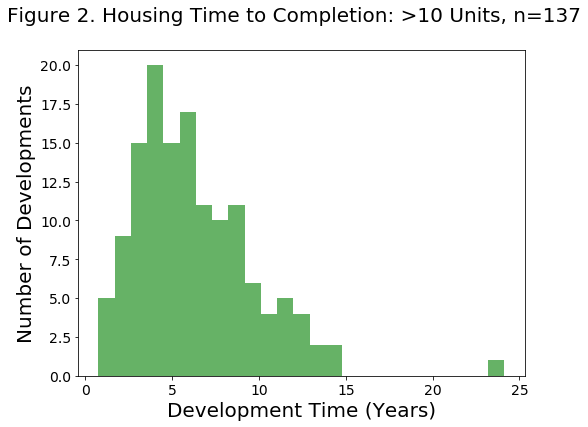

In [809]:
plt.figure(1, figsize=(8,6), )
plt.suptitle('Figure 2. Housing Time to Completion: >10 Units,'+ ' n='+str(df_big[pd.notnull(df_big['project_time_years'])].count()['project_time_years']), fontsize=20)
plt.xlabel('Development Time (Years)', fontsize = 20)
plt.ylabel('Number of Developments', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
ax = plt.hist(df_big[pd.notnull(df_big['project_time_years'])]['project_time_years'], bins=25, alpha=.6, color='g')
#plt.savefig(output+'hitogram_big_proj.png')
plt.show()

In [810]:
df_big['project_time_years'].describe()

count    137.000000
mean       6.255254
std        3.453810
min        0.750685
25%        3.854795
50%        5.945205
75%        8.273973
max       24.128767
Name: project_time_years, dtype: float64

# Figure 2. Years Per Unit Histogram

In [811]:
# Project review time, normalized by amount of units
#create unit-year category so that we normalize by units when comparing geographies
df['years_per_unit']=df['project_time_years']/df['units']

In [812]:
df['years_per_unit'].describe()

count    721.000000
mean       2.564254
std        2.491997
min        0.006109
25%        0.756164
50%        1.923288
75%        3.616438
max       13.243836
Name: years_per_unit, dtype: float64

In [813]:
df.sort_values('years_per_unit', ascending = False)[0:5]

,Unnamed: 0,Unnamed: 0.1,BP_date,address_x,aff,affnet,apn,best_date,best_stat,comp_date,con_date,dbi_permit,dropped_out,first_date,first_project_record_date,firstfiled,latest_project_record_date,latest_project_status,project_dates,project_duration_days,project_statuses,report_quarter,report_year,status,units,unitsnet,x,y,zoning,zoning_simplified,bp_duplicates,project_time_years,aff_address,address_y,Low Income Units,Placed in Service (PIS) Date,iz_address,Total BMRs in this Building or Phase,Planning Approval Date,Completion Date,_merge,geometry,index_right,nhood,permit_time,bp_time,con_time,ptime_per_unit,bptime_per_unit,contime_per_unit,zone_class,year_start,first_year,years_per_unit
2079,2079,0,NaN,1245 DOLORES ST,NaN,NaN,6534024,2006-11-30,CONSTRUCTION,10/01/2013,2006-11-30,200007074553,False,2000-07-07,2006-11-30,2000-07-07,2006-11-30,CONSTRUCTION,"('2006-11-30', '2006-11-30', '2006-11-30', '20...",4834.0,"('CONSTRUCTION', 'CONSTRUCTION', 'CONSTRUCTION...",3,2013,Under Construction,1.0,1.0,-122.424732,37.749343,RH-3,RH-3,False,13.243836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,POINT (-122.424732 37.749343),18,Mission,NaN,NaN,6.841096,NaN,NaN,6.841096,Conventional Residential,2000,2000,13.243836
2376,2376,0,2009-08-07,652 LAKEVIEW AV,0.0,0.0,7016023,2013-06-24,CONSTRUCTION,01/01/2016,2013-06-24,200311240936,False,2003-11-24,2009-08-07,2003-11-24,2013-06-24,CONSTRUCTION,"('2009-08-07', '2009-08-07', '2009-08-07', '20...",4421.0,"('BP APPROVED', 'BP APPROVED', 'BP APPROVED', ...",4,2015,Under Construction,1.0,1.0,-122.457741,37.718436,RH-1,RH-1,False,12.112329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,POINT (-122.457740668 37.7184362783),23,Oceanview/Merced/Ingleside,5.706849,3.882192,2.523288,5.706849,3.882192,2.523288,Conventional Residential,2003,2003,12.112329
1746,1746,0,2010-04-13,23 SPARTA ST,0.0,0.0,6176011,2015-12-10,CONSTRUCTION,01/01/2016,2015-05-18,200401063464,False,2004-01-06,2004-01-06,2004-01-06,2015-12-10,CONSTRUCTION,"('2004-01-06', '2010-04-13', '2010-06-04', '20...",4378.0,"('BP FILED', 'BP APPROVED', 'BP ISSUED', 'BP I...",4,2015,Under Construction,1.0,1.0,-122.403330,37.717794,RH-1,RH-1,False,11.994521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,POINT (-122.403329904 37.7177938414),38,Visitacion Valley,6.271233,5.098630,0.624658,6.271233,5.098630,0.624658,Conventional Residential,2004,2004,11.994521
1814,1814,0,2009-02-09,1310 STANYAN ST,0.0,0.0,2706035,2012-07-05,CONSTRUCTION,01/01/2016,2010-12-07,200407158977,False,2004-07-15,2009-02-09,2004-07-15,2012-07-05,CONSTRUCTION,"('2009-02-09', '2009-02-09', '2009-02-09', '20...",4187.0,"('BP APPROVED', 'BP APPROVED', 'BP APPROVED', ...",4,2015,Under Construction,1.0,1.0,-122.451007,37.758409,RH-1(D),RH-1(D),False,11.471233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,POINT (-122.451006674 37.758409222),37,Twin Peaks,4.575342,1.824658,5.071233,4.575342,1.824658,5.071233,Conventional Residential,2004,2004,11.471233
1907,1907,0,2015-01-26,4126 17TH ST,0.0,0.0,2623028,2016-07-29,CONSTRUCTION,01/01/2017,2016-07-29,201405307098,False,2005-12-08,2005-12-08,2005-12-08,2016-07-29,CONSTRUCTION,"('2005-12-08', '2005-12-08', '2005-12-08', '20...",4042.0,"('BP FILED', 'BP FILED', 'BP FILED', 'BP FILED...",4,2016,Under Construction,1.0,1.0,-122.437954,37.762612,RH-3,RH-3,False,11.073973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,POINT (-122.437954318 37.7626118963),2,Castro/Upper Market,9.139726,1.506849,0.427397,9.139726,1.506849,0.427397,Conventional Residential,2005,2005,11.073973


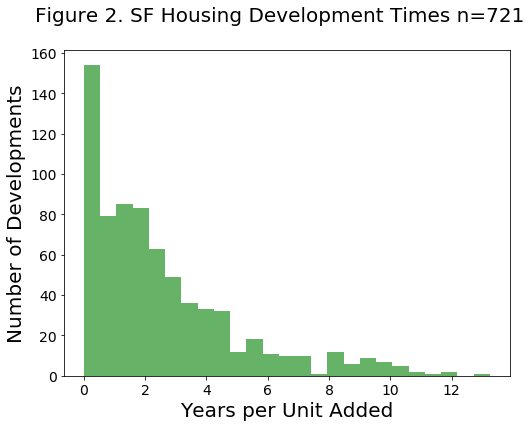

In [814]:
plt.figure(1, figsize=(8,6), )
plt.suptitle('Figure 2. SF Housing Development Times' + ' n='+str(df[pd.notnull(df['years_per_unit'])].count()['years_per_unit']), fontsize=20)
plt.xlabel('Years per Unit Added', fontsize=20)
plt.ylabel('Number of Developments', fontsize=20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
ax = plt.hist(df[pd.notnull(df['years_per_unit'])]['years_per_unit'], bins=25, alpha=.6, color='g')
plt.savefig(output+'hitogram_yearunits.png')
plt.show()

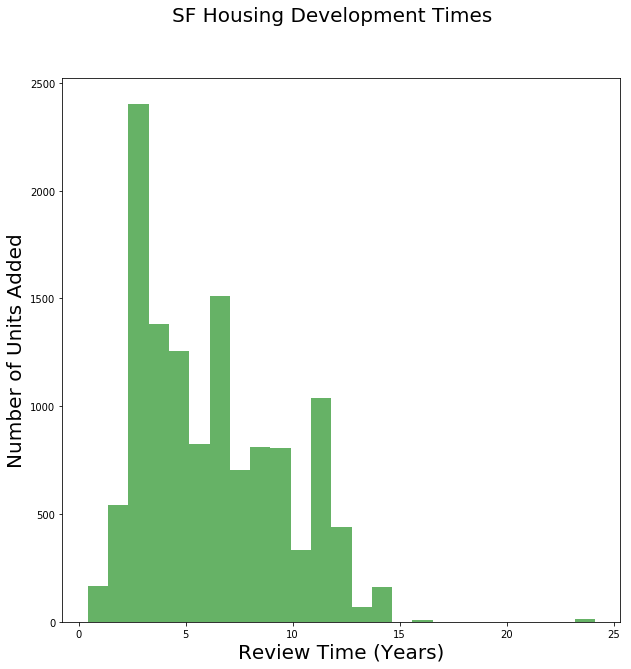

In [815]:
#Create dataset units added by years for each unit
list = []
uniqueid = 0
for index, row in df.iterrows():
    amount = int(row['units'])
    for units in range(0, amount):
        dictionary = {}
        dictionary['id']=uniqueid+1
        dictionary['time']=row['project_time_years']
        list.append(dictionary)
        uniqueid=uniqueid+1
df_units = pd.DataFrame(list)

plt.figure(1, figsize=(10,10), )
plt.suptitle('SF Housing Development Times', fontsize=20)
plt.xlabel('Review Time (Years)', fontsize = 20)
plt.ylabel('Number of Units Added', fontsize = 20)
ax = plt.hist(df_units[pd.notnull(df_units['time'])]['time'], bins=25, alpha=.6, color='g')
plt.savefig(output+'hitogram_units.png')
plt.show()

In [816]:
df_units['time'].describe()

count    12463.000000
mean         6.204317
std          3.362512
min          0.430137
25%          3.364384
50%          5.947945
75%          8.665753
max         24.128767
Name: time, dtype: float64

# Figure 4. Scatter Plots

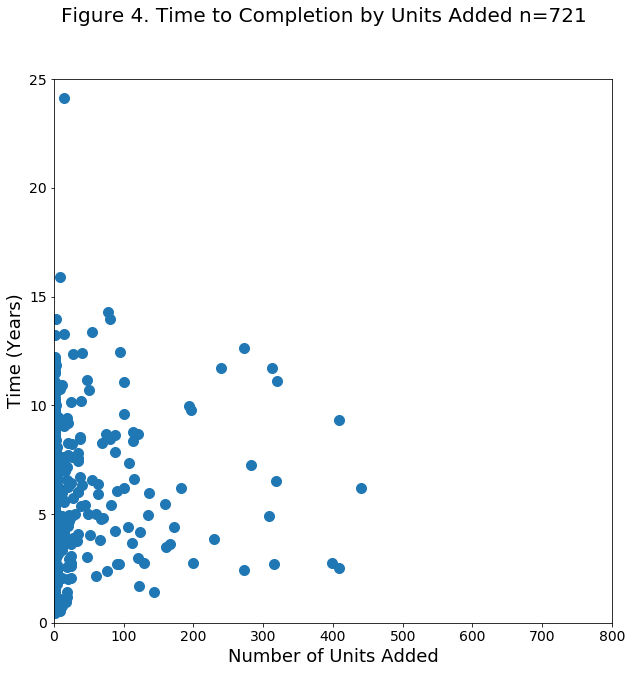

In [817]:
plt.figure(1, figsize=(10,10))
plt.scatter(df['units'], df['project_time_years'], s=100)
plt.suptitle('Figure 4. Time to Completion by Units Added' + ' n='+str(df[pd.notnull(df['project_time_years'])].count()['project_time_years']), fontsize=20)
plt.ylabel('Time (Years)', fontsize = 18)
plt.xlabel('Number of Units Added', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize = 14)
plt.xlim([0,800])
plt.ylim([0,25])
plt.savefig(output+'scatter.png')

(0, 25)

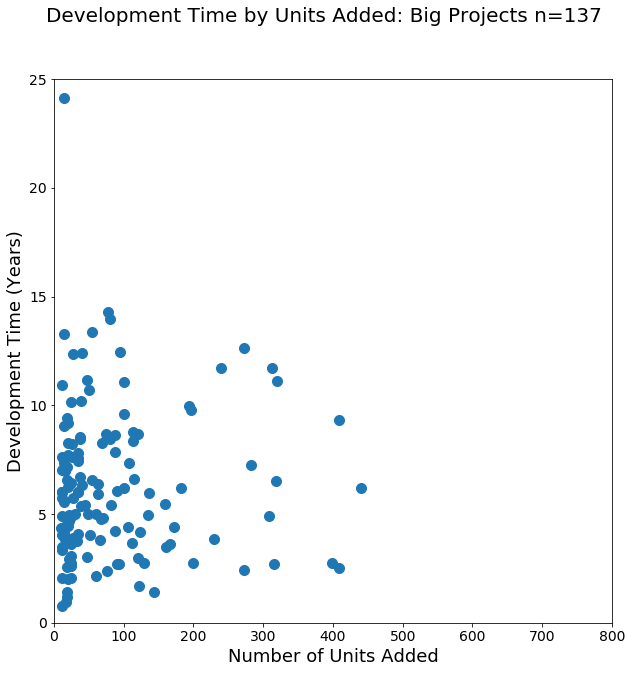

In [818]:
plt.figure(1, figsize=(10,10))
plt.scatter(df_big['units'], df_big['project_time_years'], s=100)
plt.suptitle('Development Time by Units Added: Big Projects' + ' n='+str(df_big[pd.notnull(df_big['project_time_years'])].count()['project_time_years']), fontsize=20)
plt.ylabel('Development Time (Years)', fontsize = 18)
plt.xlabel('Number of Units Added', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize = 14)
plt.xlim([0,800])
plt.ylim([0,25])

# Figure 5. Plot by unit category

In [819]:
unit_cutoffs=[10, 50, 100, 200]
def unit_categories(value):
    if value['units'] <unit_cutoffs[0]:
        field = '0'+'-'+str(unit_cutoffs[0])
    elif (value['units'] >=unit_cutoffs[0]) & (value['units'] <unit_cutoffs[1]):
        field = str(unit_cutoffs[0])+'-'+str(unit_cutoffs[1])
    elif (value['units']>= unit_cutoffs[1]) & (value['units'] <unit_cutoffs[2]):
        field = str(unit_cutoffs[1])+'-'+str(unit_cutoffs[2])
    elif (value['units']>= unit_cutoffs[2]) & (value['units'] <200):
        field = str(unit_cutoffs[2])+'-'+str(unit_cutoffs[3])
    elif value['units']>=200:
        field = '>'+str(unit_cutoffs[3])
    return field
    
df['unitcat']=df.apply(unit_categories, axis=1)
df_big['unitcat']=df_big.apply(unit_categories, axis=1)

/Users/briangoggin/anaconda/envs/OSMNX/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [820]:
df['unitcat'].value_counts()

0-10       1922
10-50       246
50-100      116
100-200      96
>200         94
Name: unitcat, dtype: int64

In [821]:
#bar_graph('unitcat','project_time_years', 'Time to Completion by Size Category','Size (Units)', 'Time (Years)')

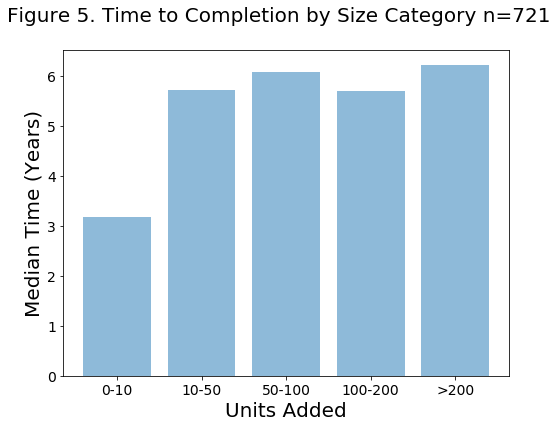

In [822]:
cat_medians=[]
categories=['0-10', '10-50', '50-100', '100-200', '>200']
for cat in categories:
    median = df[df['unitcat']==cat]['project_time_years'].median()
    cat_medians.append(median)
objects = df['unitcat'].unique()
y_pos = np.arange(len(objects))

plt.figure(1, figsize=(8,6), )
plt.suptitle('Figure 5. Time to Completion by Size Category' + ' n='+str(df[pd.notnull(df['project_time_years'])].count()['project_time_years']), fontsize=20)
plt.ylabel('Median Time (Years)', fontsize=20)
plt.xlabel('Units Added', fontsize=20)
plt.bar(y_pos, cat_medians, align='center', alpha=0.5)
plt.xticks(y_pos, categories, fontsize=14)
plt.yticks(fontsize = 14)
plt.savefig(output+'bar_chart_times.png')
plt.show()

In [823]:
def aff_status(value):
    return_val=2
    if pd.notnull(value['aff']):
        if value['aff']<value['units']:
            if value['aff']>0:
                return_val=1
            else:
                return_val=2
        elif value['aff']>=value['units']:
            return_val=0
    else:
        return_val=2
    return return_val

df['aff_status']=df.apply(aff_status, axis=1)

df['aff_status'].value_counts()

2    2254
1     167
0      53
Name: aff_status, dtype: int64

In [824]:
#create new dataframes
df_aff=df[df['aff_status']==0]
df_mix=df[df['aff_status']==1]
df_mar=df[df['aff_status']==2]
df_any_aff=df[(df['aff_status']==0) | (df['aff_status']==1)]

In [825]:
def figure5(df, title):
    cat_medians=[]
    categories=['0-10', '10-50', '50-100', '100-200', '>200']
    samplesizes=[]
    for cat in categories:
        median = df[df['unitcat']==cat]['project_time_years'].median()
        cat_medians.append(median)
        ss=str(df[(df['unitcat']==cat) & (pd.notnull(df['project_time_years']))].shape[0])
        samplesizes.append(ss)
    
    for x in range(0, 5):
        if pd.isnull(cat_medians[x]):
            cat_medians[x]=0
            
    objects = df['unitcat'].unique()
    N=5
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35  

    fig, ax = plt.subplots()
    fig.set_figheight(6)
    fig.set_figwidth(8)

    rects1 = ax.bar(ind+width, cat_medians, align='center', alpha=0.5)

    ax.set_ylabel('Median Time (Years)', fontsize=16)
    ax.set_xlabel('Units Added', fontsize=16)
    ax.set_title('Figure 5. Time to Completion by Size Category—'+title+ ' (Sample Sizes on Bars)', fontsize=16)
    ax.set_xticks(ind + width)
    ax.set_xticklabels(('0-10', '10-50', '50-100', '100-200', '>200'))

    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        i=0
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 0.5*height,
                    samplesizes[i],
                    ha='center', va='bottom')
            i=i+1
    autolabel(rects1)

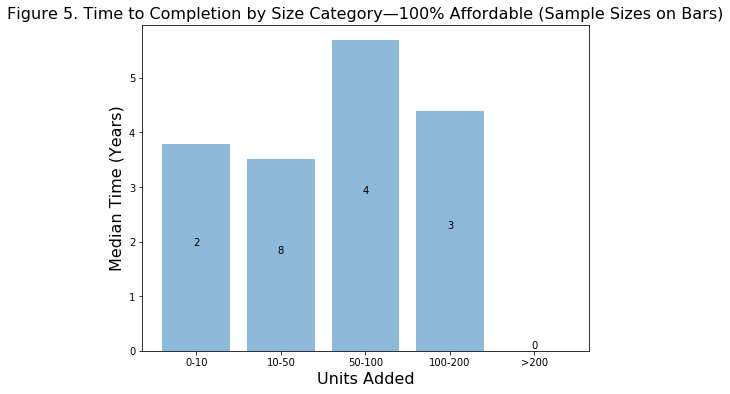

In [826]:
figure5(df_aff, "100% Affordable")

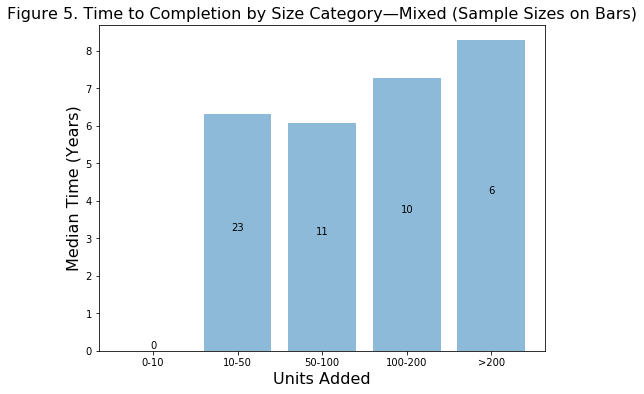

In [827]:
figure5(df_mix, "Mixed")

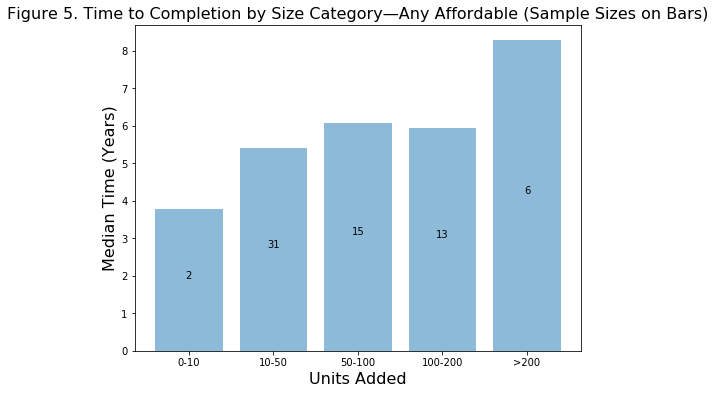

In [828]:
figure5(df_any_aff, "Any Affordable")

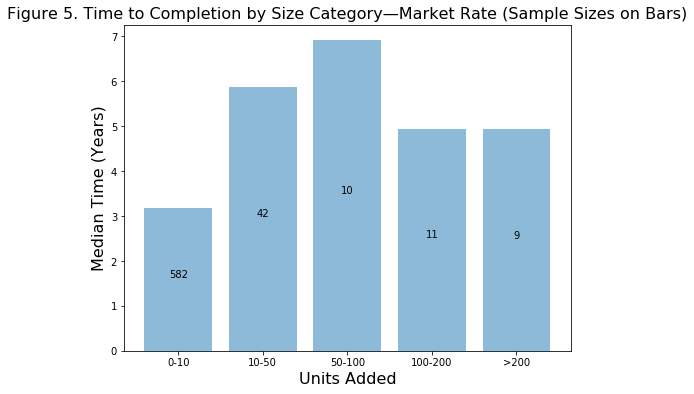

In [829]:
figure5(df_mar, 'Market Rate')

# Figures 3 and 6. Breakdown time by stage of process

In [830]:
df.shape

(2474, 56)

In [831]:
#in order to use as much data as possible, I am not keeping all data and just creating time vars where we can (i.e. where they are nonnull)
def permit_time(value):
    returnval=np.nan
    if pd.notnull(value['BP_date']) & pd.notnull(value['first_date']):
        returnval=((dateutil.parser.parse(value['BP_date']) - dateutil.parser.parse(value['first_date'])).days)/365
    return returnval
def bp_time(value):
    returnval=np.nan
    if pd.notnull(value['con_date']) & pd.notnull(value['BP_date']):
        returnval=((dateutil.parser.parse(value['con_date']) - dateutil.parser.parse(value['BP_date'])).days)/365
    return returnval
def con_time(value):
    returnval=np.nan
    if pd.notnull(value['comp_date']) & pd.notnull(value['con_date']):
        returnval=((dateutil.parser.parse(value['comp_date']) - dateutil.parser.parse(value['con_date'])).days)/365
    return returnval
    
df['permit_time']=df.apply(permit_time, axis=1)
df['bp_time']=df.apply(bp_time, axis=1)
df['con_time']=df.apply(con_time, axis=1)

In [832]:
#Final sample with at least one nonmissing piece of relevant information. leaving other observations in because they don't affect graphs anyway
df[(pd.isnull(df['con_time'])) & (pd.isnull(df['permit_time'])) & (pd.isnull(df['bp_time'])) & (pd.isnull(df['project_time_years']))].shape

(1147, 56)

In [833]:
df['permit_time'].describe()

count    1089.000000
mean        2.113790
std         2.035939
min         0.002740
25%         0.819178
50%         1.476712
75%         2.575342
max        13.934247
Name: permit_time, dtype: float64

In [834]:
df['bp_time'].describe()

count    650.000000
mean       1.116902
std        1.218792
min        0.054795
25%        0.417123
50%        0.704110
75%        1.286301
max        7.717808
Name: bp_time, dtype: float64

In [835]:
df['con_time'].describe()

count    721.000000
mean       1.232257
std        1.382572
min        0.000000
25%        0.427397
50%        0.816438
75%        1.473973
max        8.810959
Name: con_time, dtype: float64

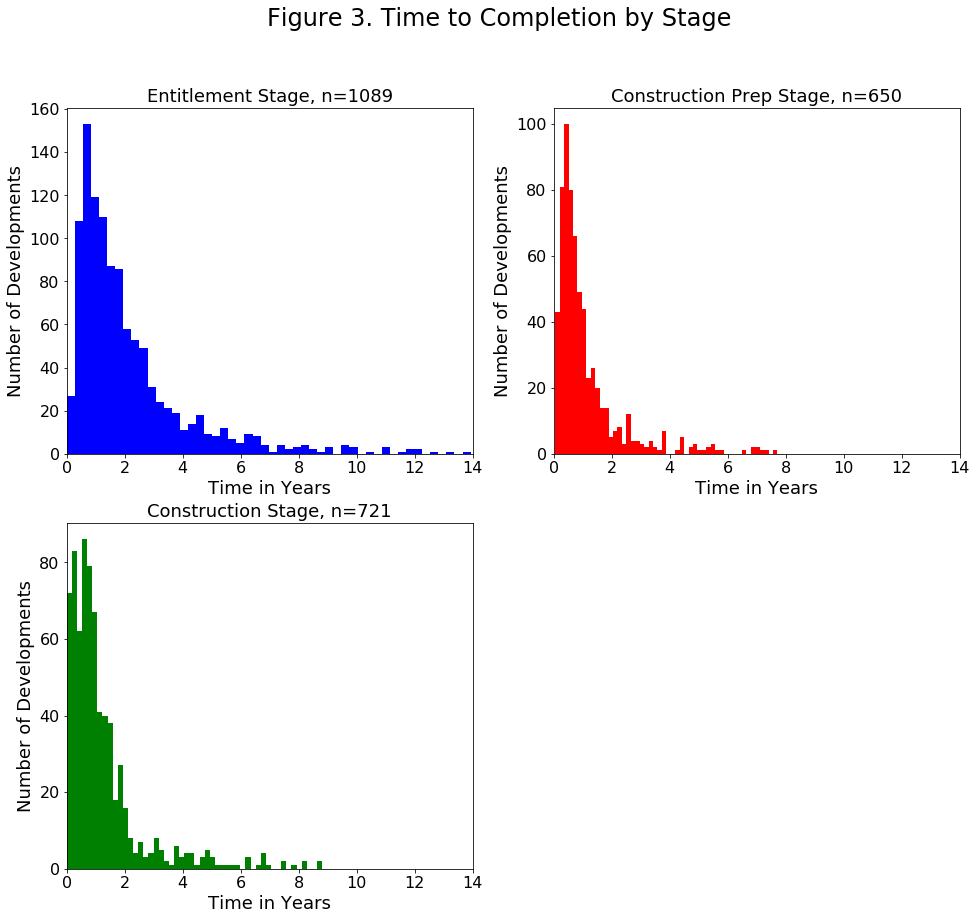

In [836]:
plt.figure(1, figsize=(16,14), )
plt.suptitle("Figure 3. Time to Completion by Stage", fontsize=24)

ax = plt.subplot(221)
ax.set_title("Entitlement Stage,"+ ' n='+str(df[pd.notnull(df['permit_time'])].count()['permit_time']), fontsize=18)
ax.set_xlabel('Time in Years', fontsize=18)
ax.set_ylabel('Number of Developments', fontsize=18)
plt.xlim([0,14])
#plt.ylim([0,80])
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
ax.hist(df[pd.notnull(df['permit_time'])]['permit_time'], bins=50, color='b')

ax = plt.subplot(222)
ax.set_title("Construction Prep Stage," + ' n='+str(df[pd.notnull(df['bp_time'])].count()['bp_time']), fontsize=18)
ax.set_xlabel('Time in Years', fontsize=18)
ax.set_ylabel('Number of Developments', fontsize=18)
plt.xlim([0,14])
#plt.ylim([0,80])
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
ax.hist(df[pd.notnull(df['bp_time'])]['bp_time'], bins=50, color='r')

ax = plt.subplot(223)
ax.set_title("Construction Stage,"+ ' n='+str(df[pd.notnull(df['con_time'])].count()['con_time']), fontsize=18)
ax.set_xlabel('Time in Years', fontsize=18)
ax.set_ylabel('Number of Developments', fontsize=18)
plt.xlim([0,14])
#plt.ylim([0,80])
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
ax.hist(df[pd.notnull(df['con_time'])]['con_time'], bins=50, color='g')

plt.savefig(output+'big_hist.png')

In [837]:
def recession(value):
    return_value=True
    if dateutil.parser.parse(value['first_date'])<dateutil.parser.parse('09/15/2008'):
        return_value=False
    return return_value

df['post_recession']=df.apply(recession, axis=1)

In [838]:
df_rec=df[df['post_recession']==False]
df_not_rec=df[df['post_recession']==True]      

In [839]:
def figure3time(df, title):
    plt.figure(1, figsize=(16,14), )
    plt.suptitle("Figure 3. Time to Completion by Stage: "+ title, fontsize=24)

    ax = plt.subplot(221)
    ax.set_title("Entitlement Stage,"+ ' n='+str(df[pd.notnull(df['permit_time'])].count()['permit_time']), fontsize=18)
    ax.set_xlabel('Time in Years', fontsize=18)
    ax.set_ylabel('Number of Developments', fontsize=18)
    plt.xlim([0,14])
    #plt.ylim([0,80])
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    ax.hist(df[pd.notnull(df['permit_time'])]['permit_time'], bins=50, color='b',  edgecolor='black', linewidth=1.2)

    ax = plt.subplot(222)
    ax.set_title("Construction Prep Stage," + ' n='+str(df[pd.notnull(df['bp_time'])].count()['bp_time']), fontsize=18)
    ax.set_xlabel('Time in Years', fontsize=18)
    ax.set_ylabel('Number of Developments', fontsize=18)
    plt.xlim([0,14])
    #plt.ylim([0,80])
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    ax.hist(df[pd.notnull(df['bp_time'])]['bp_time'], bins=50, color='r',  edgecolor='black', linewidth=1.2)

    ax = plt.subplot(223)
    ax.set_title("Construction Stage,"+ ' n='+str(df[pd.notnull(df['con_time'])].count()['con_time']), fontsize=18)
    ax.set_xlabel('Time in Years', fontsize=18)
    ax.set_ylabel('Number of Developments', fontsize=18)
    plt.xlim([0,14])
    #plt.ylim([0,80])
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    ax.hist(df[pd.notnull(df['con_time'])]['con_time'], bins=50, color='g',  edgecolor='black', linewidth=1.2)

    #plt.savefig(output+'big_hist.png')

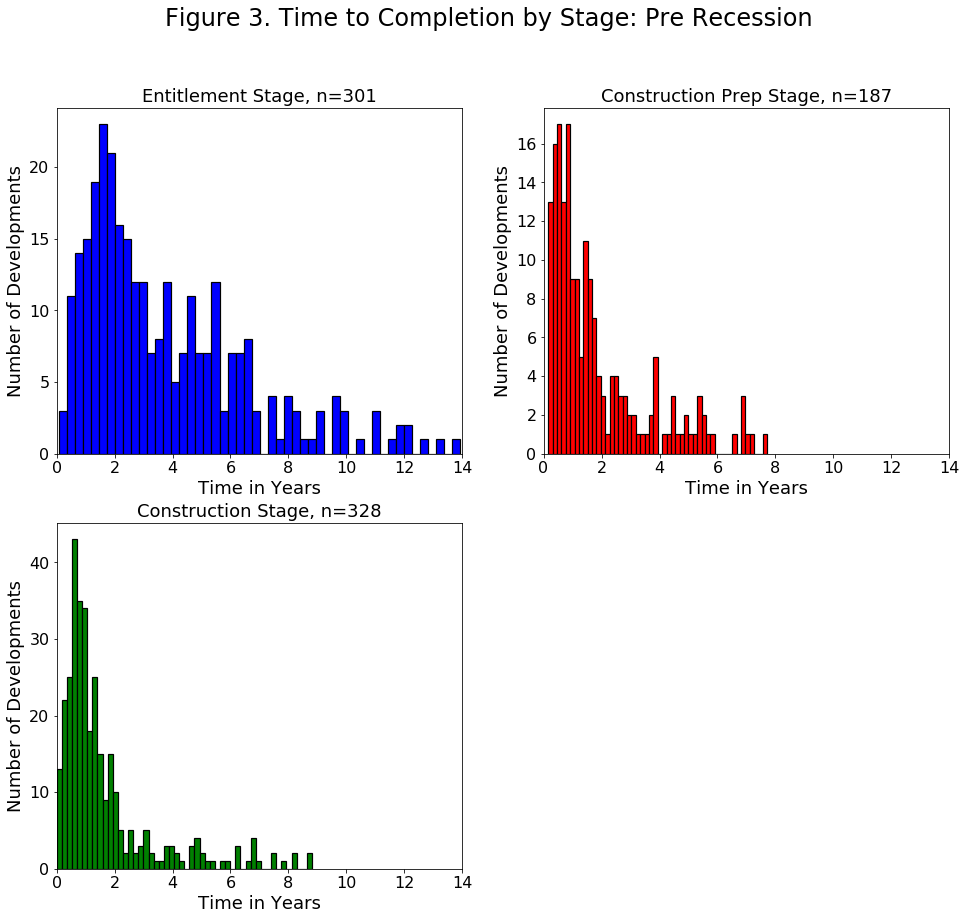

In [840]:
figure3time(df_rec, "Pre Recession")

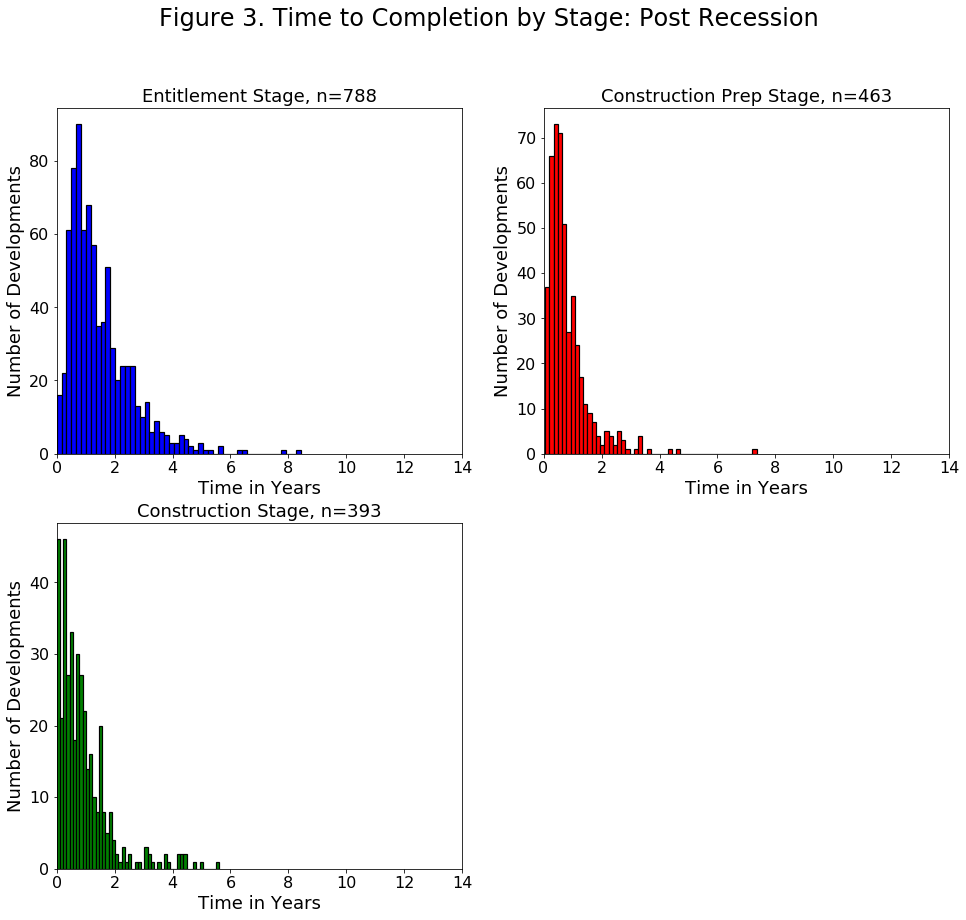

In [841]:
figure3time(df_not_rec, "Post Recession")

In [842]:
#do some t-tests
from scipy.stats import ttest_ind

print ("Entitlement Time:")
print (df_rec['permit_time'].mean().astype(str), df_not_rec['permit_time'].mean().astype(str))
print (ttest_ind(df_rec['permit_time'], df_not_rec['permit_time'], nan_policy='omit')[1].astype(str))
print (str(df_rec[pd.notnull(df_rec['permit_time'])].count()['permit_time']))
print (str(df_not_rec[pd.notnull(df_not_rec['permit_time'])].count()['permit_time']))

print ("Cons Prep Time:")
print (df_rec['bp_time'].mean().astype(str), df_not_rec['bp_time'].mean().astype(str))
print (ttest_ind(df_rec['bp_time'], df_not_rec['bp_time'], nan_policy='omit')[1].astype(str))
print (str(df_rec[pd.notnull(df_rec['bp_time'])].count()['bp_time']))
print (str(df_not_rec[pd.notnull(df_not_rec['bp_time'])].count()['bp_time']))

print ("Cons Prep Time:")
print (df_rec['con_time'].mean().astype(str), df_not_rec['con_time'].mean().astype(str))
print (ttest_ind(df_rec['con_time'], df_not_rec['con_time'], nan_policy='omit')[1].astype(str))
print (str(df_rec[pd.notnull(df_rec['con_time'])].count()['con_time']))
print (str(df_not_rec[pd.notnull(df_not_rec['con_time'])].count()['con_time']))

Entitlement Time:
3.7721021253356395 1.4803490716918155
4.2015432566085645e-71
301
788
Cons Prep Time:
1.869430810929602 0.8129648806177698
2.1436596243194105e-25
187
463
Cons Prep Time:
1.6227363848980956 0.9063613231552164
1.9131448644407402e-12
328
393


## Breakdown by Affordable, Mixed, Market Rate

In [843]:
def figure3(df, title):
    plt.figure(1, figsize=(16,14), )
    plt.suptitle("Figure 3. Time to Completion by Stage: "+title, fontsize=24)

    ax = plt.subplot(221)
    ax.set_title("Entitlement Stage,"+ ' n='+str(df[pd.notnull(df['permit_time'])].count()['permit_time']), fontsize=18)
    ax.set_xlabel('Time in Years', fontsize=18)
    ax.set_ylabel('Number of Developments', fontsize=18)
    plt.xlim([0,14])
    #plt.ylim([0,80])
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    ax.hist(df[pd.notnull(df['permit_time'])]['permit_time'], bins=25, color='b',  edgecolor='black', linewidth=1.2)

    ax = plt.subplot(222)
    ax.set_title("Construction Prep Stage," + ' n='+str(df[pd.notnull(df['bp_time'])].count()['bp_time']), fontsize=18)
    ax.set_xlabel('Time in Years', fontsize=18)
    ax.set_ylabel('Number of Developments', fontsize=18)
    plt.xlim([0,14])
    #plt.ylim([0,80])
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    ax.hist(df[pd.notnull(df['bp_time'])]['bp_time'], bins=25, color='r',  edgecolor='black', linewidth=1.2)

    ax = plt.subplot(223)
    ax.set_title("Construction Stage,"+ ' n='+str(df[pd.notnull(df['con_time'])].count()['con_time']), fontsize=18)
    ax.set_xlabel('Time in Years', fontsize=18)
    ax.set_ylabel('Number of Developments', fontsize=18)
    plt.xlim([0,14])
    #plt.ylim([0,80])
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    ax.hist(df[pd.notnull(df['con_time'])]['con_time'], bins=25, color='g',  edgecolor='black', linewidth=1.2)

#plt.savefig(output+'big_hist.png')

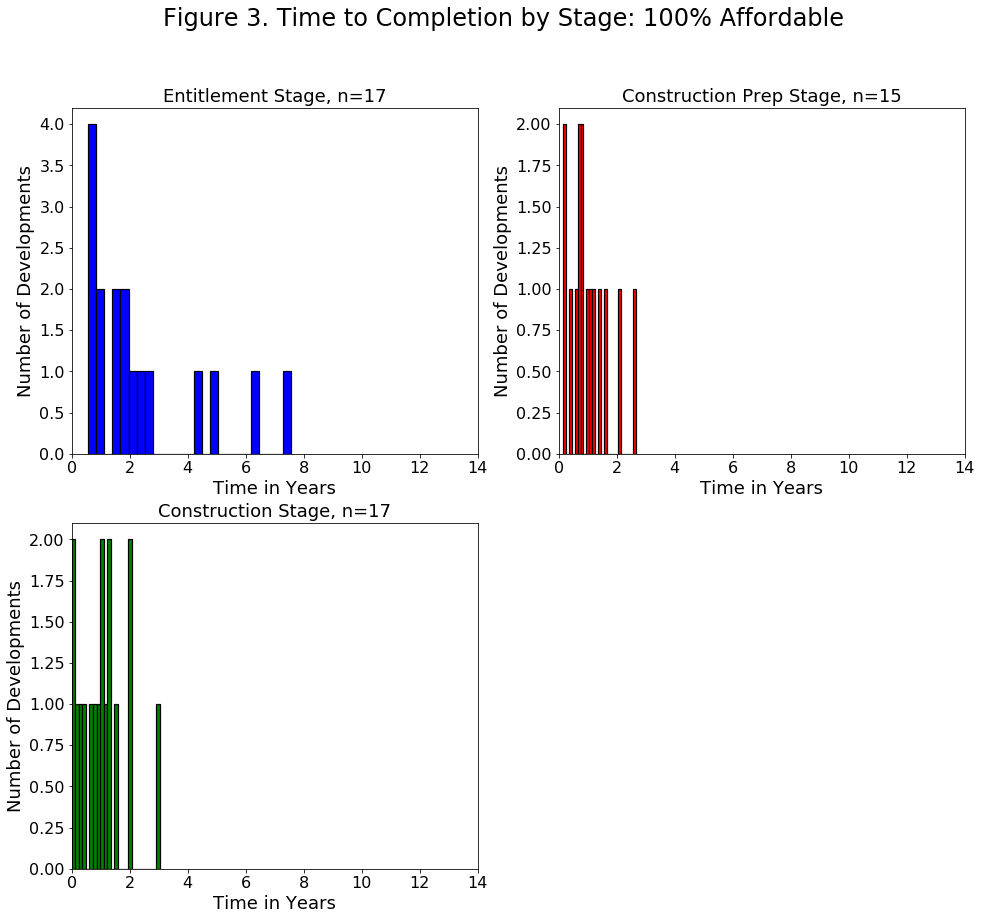

In [844]:
figure3(df_aff, '100% Affordable')

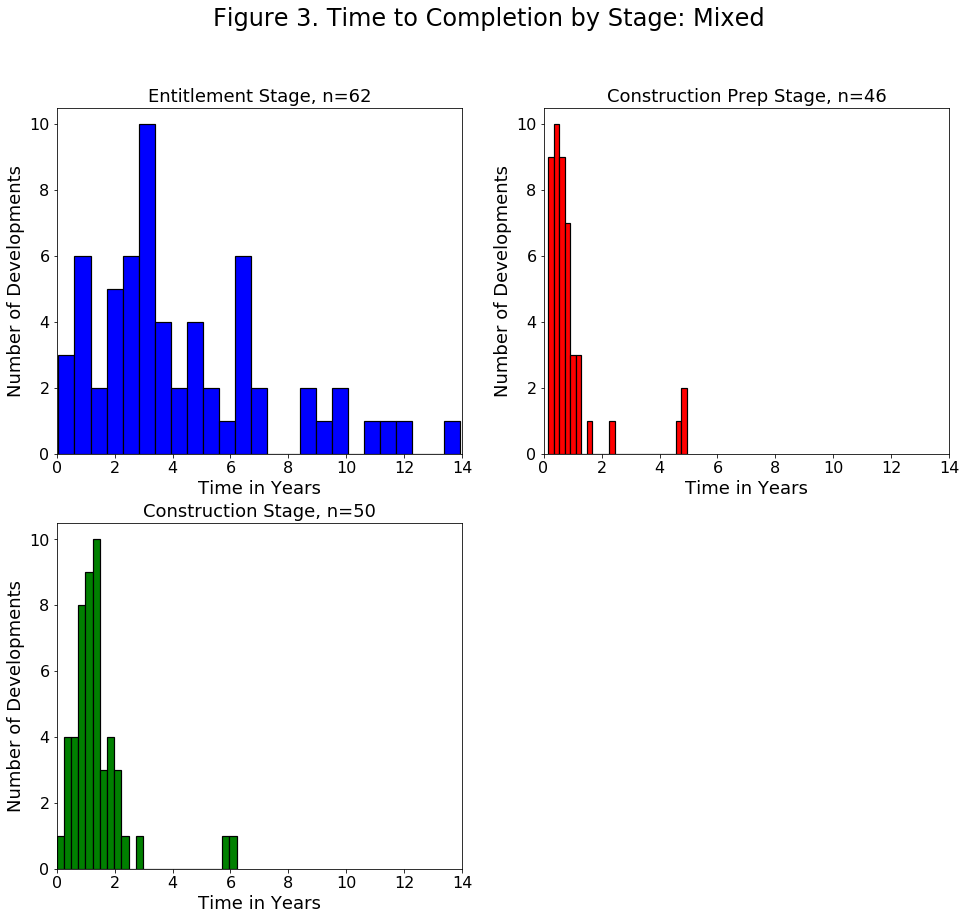

In [845]:
figure3(df_mix, "Mixed")

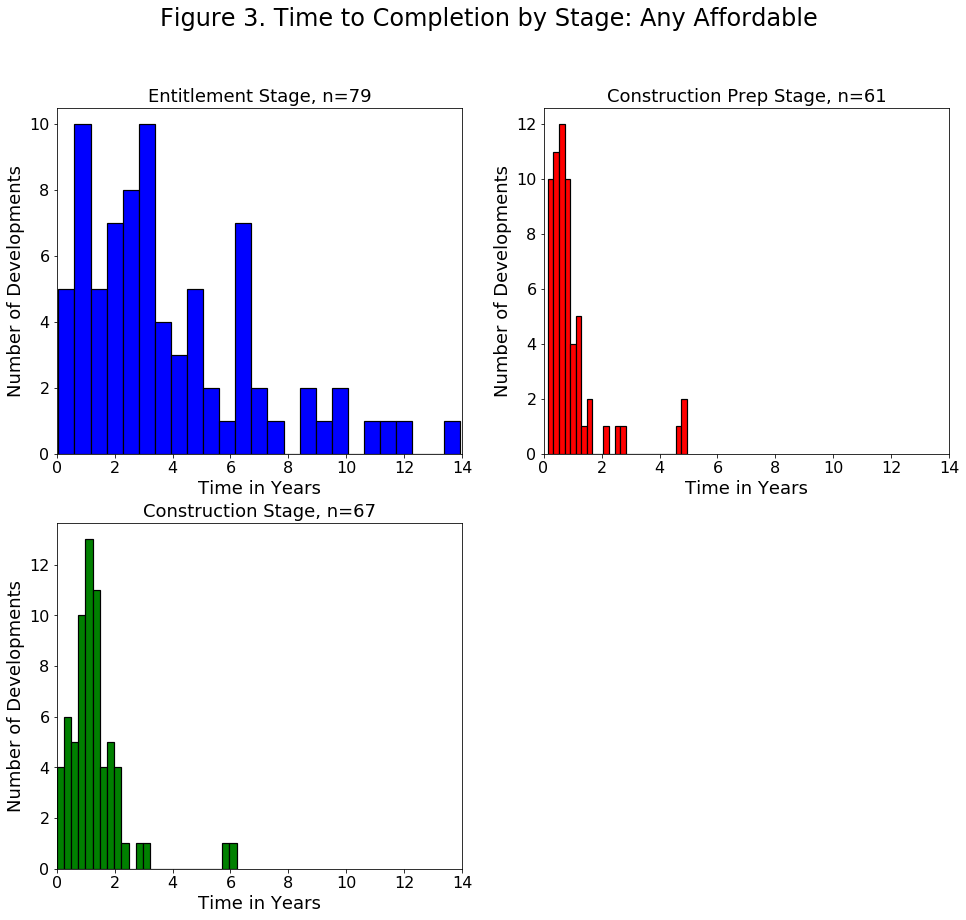

In [847]:
figure3(df_any_aff, "Any Affordable")

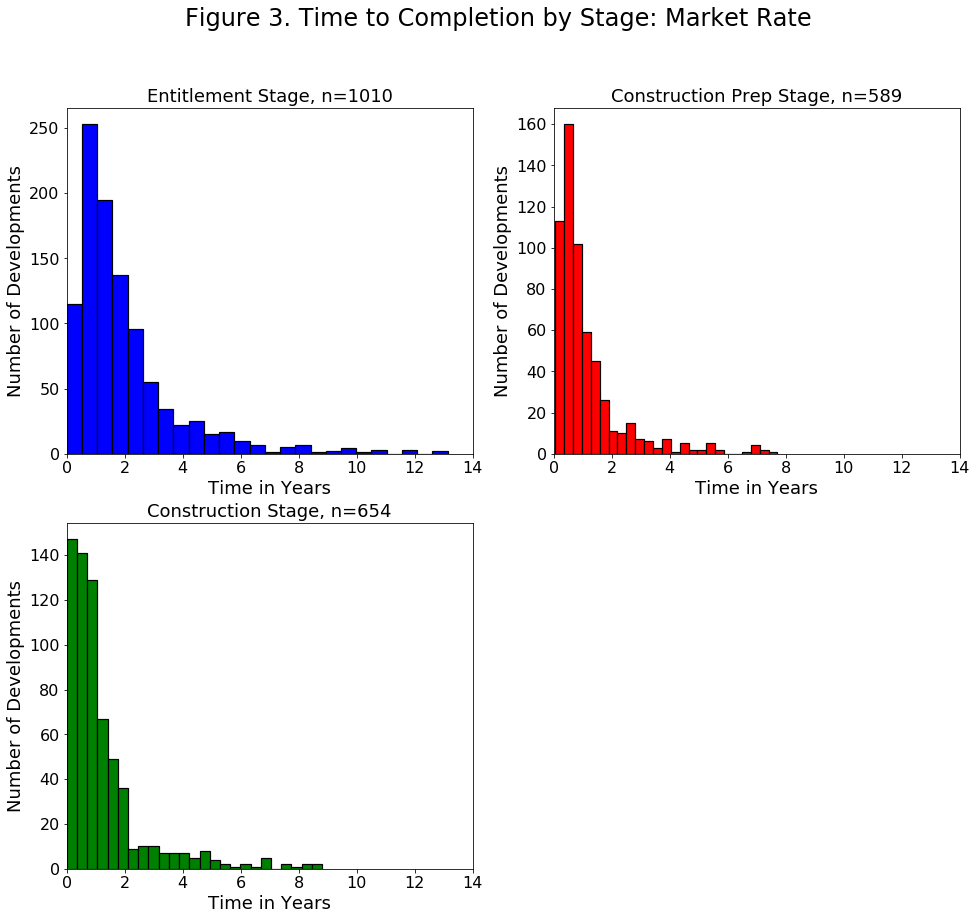

In [846]:
figure3(df_mar, "Market Rate")

In [768]:
#do some t-tests
from scipy.stats import ttest_ind

print ("Entitlement Time:")
print (df_aff['permit_time'].mean().astype(str), df_mix['permit_time'].mean().astype(str), 
      df_any_aff['permit_time'].mean().astype(str), df_mar['permit_time'].mean().astype(str))

print (ttest_ind(df_aff['permit_time'], df_mar['permit_time'], nan_policy='omit')[1].astype(str))
print (ttest_ind(df_mix['permit_time'], df_mar['permit_time'], nan_policy='omit')[1].astype(str))
print (ttest_ind(df_any_aff['permit_time'], df_mar['permit_time'], nan_policy='omit')[1].astype(str))

print (str(df_aff[pd.notnull(df_aff['permit_time'])].count()['permit_time']))
print (str(df_mix[pd.notnull(df_mix['permit_time'])].count()['permit_time']))
print (str(df_any_aff[pd.notnull(df_any_aff['permit_time'])].count()['permit_time']))
print (str(df_mar[pd.notnull(df_mar['permit_time'])].count()['permit_time']))


print ("Construction Prep Time: ")
print (df_aff['bp_time'].mean().astype(str),df_mix['bp_time'].mean().astype(str), 
       df_any_aff['bp_time'].mean().astype(str), df_mar['bp_time'].mean().astype(str))

print (ttest_ind(df_aff['bp_time'], df_mar['bp_time'], nan_policy='omit')[1].astype(str))
print (ttest_ind(df_mix['bp_time'], df_mar['bp_time'], nan_policy='omit')[1].astype(str))
print (ttest_ind(df_any_aff['bp_time'], df_mar['bp_time'], nan_policy='omit')[1].astype(str))

print (str(df_aff[pd.notnull(df_aff['bp_time'])].count()['bp_time']))
print (str(df_mix[pd.notnull(df_mix['bp_time'])].count()['bp_time']))
print (str(df_any_aff[pd.notnull(df_any_aff['bp_time'])].count()['bp_time']))
print (str(df_mar[pd.notnull(df_mar['bp_time'])].count()['bp_time']))

print ("Construction Time: ")
print (df_aff['con_time'].mean().astype(str),df_mix['con_time'].mean().astype(str), 
       df_any_aff['con_time'].mean().astype(str), df_mar['con_time'].mean().astype(str))

print (ttest_ind(df_aff['con_time'], df_mar['con_time'], nan_policy='omit')[1].astype(str))
print (ttest_ind(df_mix['con_time'], df_mar['con_time'], nan_policy='omit')[1].astype(str))
print (ttest_ind(df_any_aff['con_time'], df_mar['con_time'], nan_policy='omit')[1].astype(str))

print (str(df_aff[pd.notnull(df_aff['con_time'])].count()['con_time']))
print (str(df_mix[pd.notnull(df_mix['con_time'])].count()['con_time']))
print (str(df_any_aff[pd.notnull(df_any_aff['con_time'])].count()['con_time']))
print (str(df_mar[pd.notnull(df_mar['con_time'])].count()['con_time']))

print ("Total Time: ")
print (df_aff['project_time_years'].mean().astype(str),df_mix['project_time_years'].mean().astype(str), 
       df_any_aff['project_time_years'].mean().astype(str), df_mar['project_time_years'].mean().astype(str))

print (ttest_ind(df_aff['project_time_years'], df_mar['project_time_years'], nan_policy='omit')[1].astype(str))
print (ttest_ind(df_mix['project_time_years'], df_mar['project_time_years'], nan_policy='omit')[1].astype(str))
print (ttest_ind(df_any_aff['project_time_years'], df_mar['project_time_years'], nan_policy='omit')[1].astype(str))

print (str(df_aff[pd.notnull(df_aff['project_time_years'])].count()['project_time_years']))
print (str(df_mix[pd.notnull(df_mix['project_time_years'])].count()['project_time_years']))
print (str(df_any_aff[pd.notnull(df_any_aff['project_time_years'])].count()['project_time_years']))
print (str(df_mar[pd.notnull(df_mar['project_time_years'])].count()['project_time_years']))

Entitlement Time:
2.4741337630942786 4.389217852408308 3.977111149644529 1.968045571680456
0.26716248123636627
1.888425301992746e-20
9.126304336328584e-18
17
62
79
1010
Construction Prep Time: 
1.0405479452054796 0.9391899940440737 0.9641140803952392 1.1327255389910924
0.7739328516814988
0.3039589981760341
0.3040554276961905
15
46
61
589
Construction Time: 
1.0381950040290087 1.3950684931506852 1.3045185033735431 1.2248544258723977
0.5877799182271202
0.4055796218425436
0.6536069992562057
17
50
67
654
Total Time: 
4.493150684931508 6.6666301369863 6.115150276017175 4.253370198148382
0.745163751038978
6.237943671698413e-08
1.6900044915316352e-06
17
50
67
654


In [ ]:
#do some t-tests
from scipy.stats import ttest_ind

print ("Entitlement Time:")
print (df_aff['permit_time'].mean().astype(str), df_mix['permit_time'].mean().astype(str), 
      df_any_aff['permit_time'].mean().astype(str), df_mar['permit_time'].mean().astype(str))

print (ttest_ind(df_aff['permit_time'], df_mar['permit_time'], nan_policy='omit')[1].astype(str))
print (ttest_ind(df_mix['permit_time'], df_mar['permit_time'], nan_policy='omit')[1].astype(str))
print (ttest_ind(df_any_aff['permit_time'], df_mar['permit_time'], nan_policy='omit')[1].astype(str))

print (str(df_aff[pd.notnull(df_aff['permit_time'])].count()['permit_time']))
print (str(df_mix[pd.notnull(df_mix['permit_time'])].count()['permit_time']))
print (str(df_any_aff[pd.notnull(df_any_aff['permit_time'])].count()['permit_time']))
print (str(df_mar[pd.notnull(df_mar['permit_time'])].count()['permit_time']))


print ("Construction Prep Time: ")
print (df_aff['bp_time'].mean().astype(str),df_mix['bp_time'].mean().astype(str), 
       df_any_aff['bp_time'].mean().astype(str), df_mar['bp_time'].mean().astype(str))

print (ttest_ind(df_aff['bp_time'], df_mar['bp_time'], nan_policy='omit')[1].astype(str))
print (ttest_ind(df_mix['bp_time'], df_mar['bp_time'], nan_policy='omit')[1].astype(str))
print (ttest_ind(df_any_aff['bp_time'], df_mar['bp_time'], nan_policy='omit')[1].astype(str))

print (str(df_aff[pd.notnull(df_aff['bp_time'])].count()['bp_time']))
print (str(df_mix[pd.notnull(df_mix['bp_time'])].count()['bp_time']))
print (str(df_any_aff[pd.notnull(df_any_aff['bp_time'])].count()['bp_time']))
print (str(df_mar[pd.notnull(df_mar['bp_time'])].count()['bp_time']))

print ("Construction Time: ")
print (df_aff['con_time'].mean().astype(str),df_mix['con_time'].mean().astype(str), 
       df_any_aff['con_time'].mean().astype(str), df_mar['con_time'].mean().astype(str))

print (ttest_ind(df_aff['con_time'], df_mar['con_time'], nan_policy='omit')[1].astype(str))
print (ttest_ind(df_mix['con_time'], df_mar['con_time'], nan_policy='omit')[1].astype(str))
print (ttest_ind(df_any_aff['con_time'], df_mar['con_time'], nan_policy='omit')[1].astype(str))

print (str(df_aff[pd.notnull(df_aff['con_time'])].count()['con_time']))
print (str(df_mix[pd.notnull(df_mix['con_time'])].count()['con_time']))
print (str(df_any_aff[pd.notnull(df_any_aff['con_time'])].count()['con_time']))
print (str(df_mar[pd.notnull(df_mar['con_time'])].count()['con_time']))

print ("Total Time: ")
print (df_aff['project_time_years'].mean().astype(str),df_mix['project_time_years'].mean().astype(str), 
       df_any_aff['project_time_years'].mean().astype(str), df_mar['project_time_years'].mean().astype(str))

print (ttest_ind(df_aff['project_time_years'], df_mar['project_time_years'], nan_policy='omit')[1].astype(str))
print (ttest_ind(df_mix['project_time_years'], df_mar['project_time_years'], nan_policy='omit')[1].astype(str))
print (ttest_ind(df_any_aff['project_time_years'], df_mar['project_time_years'], nan_policy='omit')[1].astype(str))

print (str(df_aff[pd.notnull(df_aff['project_time_years'])].count()['project_time_years']))
print (str(df_mix[pd.notnull(df_mix['project_time_years'])].count()['project_time_years']))
print (str(df_any_aff[pd.notnull(df_any_aff['project_time_years'])].count()['project_time_years']))
print (str(df_mar[pd.notnull(df_mar['project_time_years'])].count()['project_time_years']))

In [779]:
print ("Entitlement Time:")
print (df_aff['ptime_per_unit'].mean().astype(str), df_mix['ptime_per_unit'].mean().astype(str), 
      df_any_aff['ptime_per_unit'].mean().astype(str), df_mar['ptime_per_unit'].mean().astype(str))

print (ttest_ind(df_aff['ptime_per_unit'], df_mar['ptime_per_unit'], nan_policy='omit')[1].astype(str))
print (ttest_ind(df_mix['ptime_per_unit'], df_mar['ptime_per_unit'], nan_policy='omit')[1].astype(str))
print (ttest_ind(df_any_aff['ptime_per_unit'], df_mar['ptime_per_unit'], nan_policy='omit')[1].astype(str))

print ("Construction Prep Time: ")
print (df_aff['bptime_per_unit'].mean().astype(str),df_mix['bptime_per_unit'].mean().astype(str), 
       df_any_aff['bptime_per_unit'].mean().astype(str), df_mar['bptime_per_unit'].mean().astype(str))

print (ttest_ind(df_aff['bptime_per_unit'], df_mar['bptime_per_unit'], nan_policy='omit')[1].astype(str))
print (ttest_ind(df_mix['bptime_per_unit'], df_mar['bptime_per_unit'], nan_policy='omit')[1].astype(str))
print (ttest_ind(df_any_aff['bptime_per_unit'], df_mar['bptime_per_unit'], nan_policy='omit')[1].astype(str))

print ("Construction Time: ")
print (df_aff['contime_per_unit'].mean().astype(str),df_mix['contime_per_unit'].mean().astype(str), 
       df_any_aff['contime_per_unit'].mean().astype(str), df_mar['contime_per_unit'].mean().astype(str))

print (ttest_ind(df_aff['contime_per_unit'], df_mar['contime_per_unit'], nan_policy='omit')[1].astype(str))
print (ttest_ind(df_mix['contime_per_unit'], df_mar['contime_per_unit'], nan_policy='omit')[1].astype(str))
print (ttest_ind(df_any_aff['contime_per_unit'], df_mar['contime_per_unit'], nan_policy='omit')[1].astype(str))

print ("Total Time: ")
print (df_aff['years_per_unit'].mean().astype(str),df_mix['years_per_unit'].mean().astype(str), 
       df_any_aff['years_per_unit'].mean().astype(str), df_mar['years_per_unit'].mean().astype(str))

print (ttest_ind(df_aff['years_per_unit'], df_mar['years_per_unit'], nan_policy='omit')[1].astype(str))
print (ttest_ind(df_mix['years_per_unit'], df_mar['years_per_unit'], nan_policy='omit')[1].astype(str))
print (ttest_ind(df_any_aff['years_per_unit'], df_mar['years_per_unit'], nan_policy='omit')[1].astype(str))

Entitlement Time:
0.24544596767165228 0.10008772605954536 0.13136734767227723 1.2636113103744069
0.000901701723705817
6.844307021712153e-13
3.7233458705625115e-15
Construction Prep Time: 
0.15230937026874874 0.018606106644508322 0.05148395835538711 0.815800277486284
0.012635081395077047
1.8371779808276043e-07
9.769196677043835e-09
Construction Time: 
0.06082149420044994 0.028787419245721632 0.036915468114831804 0.886629702918069
0.008370388924986157
2.959474778171881e-06
8.937359426891057e-08
Total Time: 
0.2923878756847132 0.15620918080588833 0.1907619839840976 2.8074101719459517
3.615722817828721e-05
1.6540647101738615e-13
5.3975425394535163e-17


In [772]:
df['ptime_per_unit']=df['permit_time']/df['units']
df['bptime_per_unit']=df['bp_time']/df['units']
df['contime_per_unit']=df['con_time']/df['units']

KeyError: 'ptime_unityears'

## Figure 6. 

In [ ]:
ent_medians=[]
bp_medians=[]
cons_medians=[]
ent_number=0
bp_number=0
cons_number=0
categories=['0-10', '10-50', '50-100', '100-200', '>200']
for cat in categories:
    median1 = df[df['unitcat']==cat]['permit_time'].median()
    median2 = df[df['unitcat']==cat]['bp_time'].median()
    median3 = df[df['unitcat']==cat]['con_time'].median()
    ent_number=ent_number+df[df['unitcat']==cat]['permit_time'].count() #count sample size for non-missing y variable
    bp_number=bp_number+df[df['unitcat']==cat]['bp_time'].count()
    cons_number=cons_number+df[df['unitcat']==cat]['con_time'].count()
    
    ent_medians.append(median1)
    bp_medians.append(median2)
    cons_medians.append(median3)
objects = df['unitcat'].unique()
y_pos = np.arange(len(objects))

In [ ]:
plt.figure(1, figsize=(16,14), )
plt.suptitle("Figure 6. Time to Completion by Size Category", fontsize=24)

ax = plt.subplot(221)
ax.set_title('Median Entitlement Time'+' n='+str(ent_number), fontsize=18)
ax.set_xlabel('Number of Units', fontsize=18)
ax.set_ylabel('Median Time (Years)', fontsize=18)
ax.set_xticks(y_pos)
ax.set_xticklabels(categories)
ax.set_ylim([0,4])
ax.bar(y_pos, ent_medians, align='center', color='b')

ax = plt.subplot(222)
ax.set_title('Median Construction Prep Time'+' n='+str(bp_number), fontsize=18)
ax.set_xlabel('Number of Units', fontsize=18)
ax.set_ylabel('Median Time (Years)', fontsize=18)
ax.set_xticks(y_pos)
ax.set_xticklabels(categories)
ax.set_ylim([0,4])
ax.bar(y_pos, bp_medians, align='center', color='r')

ax = plt.subplot(223)
ax.set_title('Median Construction  Time'+' n='+str(cons_number), fontsize=18)
ax.set_xlabel('Number of Units', fontsize=18)
ax.set_ylabel('Median Time (Years)', fontsize=18)
ax.set_xticks(y_pos)
ax.set_xticklabels(categories)
ax.set_ylim([0,4])
ax.bar(y_pos, cons_medians, align='center', color='g')

plt.savefig(output+'big_bar.png')

# Figures 7 and 8. Create Neighborhood Graphs

In [ ]:
# for these graphs, drop if neighborhood has sample with non-missing BP date less than 10. Brings sample for completed projects down to 692
for nhood in df['nhood'].value_counts().index:
    if df[df['nhood']==nhood]['BP_date'].count() <10:
        df=df[df['nhood']!=nhood]

In [ ]:
df['ptime_unityears']=df['permit_time']/df['units']

In [ ]:
graph_options=['b', (12, 8)]
bar_graph('nhood','years_per_unit', 'Figure 7. Time to Completion by Neighborhood', 'Neighborhood', 'Median Time (Years per Unit)', df, True, graph_options)

In [ ]:
graph_options=['r', (12, 8)]
bar_graph('nhood','ptime_unityears', 'Figure 8. Entitlement Time by Neighborhood', 'Neighborhood', 'Median Time (Years per Unit)', df, True, graph_options)

In [ ]:
graph_options=['g', (12, 8)]
bar_graph('nhood','project_time_years', 'SF Time to Completion by Neighborhood', 'Neighborhood', 'Median Time (Years)', df, True, graph_options)

In [ ]:
graph_options=['gold', (12, 8)]
bar_graph('nhood','permit_time', 'Entitlement by Neighborhood', 'Neighborhood', 'Median Time (Years)', df, True, graph_options)